In [14]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from problem import get_train_data, get_test_data

In [22]:
def compute_rolling_std(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_mean(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "mean", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).mean()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_median(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "median", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).median()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    return X_df


def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    return X_df

def clip_column(X_df, column, min, max):
    X_df[column] = X_df[column].clip(min, max)
    return X_df

def smoothing(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        if y[:,0][range(i,i+factor)].mean() > 0.5:
            y[:,0][range(i,i+factor)] = 0.99 + 10**-15
            y[:,1][range(i,i+factor)] = 0.01 - 10**-15
        else:
            y[:,0][range(i,i+factor)] = 0.01 - 10**-15
            y[:,1][range(i,i+factor)] = 0.99 + 10**-15
        i+=factor
    return y

def smoothing2(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        y[:,0][range(i,i+factor)] = y[:,0][range(i,i+factor)].mean()
        y[:,1][range(i,i+factor)] = y[:,1][range(i,i+factor)].mean()
        i+=factor
    return y

def smoothingp(y, factor):
    i=0
    factor = 18
    while i < (y.shape[0]+1-factor):
        y[range(i, i+factor)] = 0
        i+=factor
    return y
    
def smoothingroll(y, factor):
    y2 = y.copy()
    i=factor
    factor = factor
    while i < (y.shape[0]+1-factor):
        y2[:,0][i] = (y[:,0][range(i-factor,i+factor)].mean())
        y2[:,1][i] = (y[:,1][range(i-factor,i+factor)].mean())
        i+=1
    return y2

def smoothingroll2(y, factor):
    kernel = np.ones(factor)/factor
    kernel = [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1]

    kernel = 5*[1] + 5*[3] + 10*[5] + 5*[3] + 5*[1]
    kernel = (kernel/np.sum(kernel))
    y[:,0] = np.convolve(y[:,0], kernel, 'same')
    y[:,1] = np.convolve(y[:,1], kernel, 'same')
    return y
        
def smoothingroll3(y, factor, quantile):
    y = pd.DataFrame(y)
    y[1] = y[1].rolling(factor, min_periods=0, center=True).quantile(quantile)
    y[0] = 1-y[1].ffill().bfill()
    y = y.to_numpy()
    return y




def transform(X):
    X = clip_column(X, 'Beta', 0, 500)
    X = clip_column(X, "B", 0, 1000)
    X = clip_column(X, "RmsBob", 0, 20)
    X = clip_column(X, "Vth", 0, 200)
    X = clip_column(X, "Vx", 0, 500)
    X = clip_column(X, "Np", 0, 100)
    X = clip_column(X, "Range F 13", 0, 10**9)
    X["Sum_Ranges"] = X["Range F 0"] + X["Range F 1"] + X["Range F 2"] + X["Range F 3"] + X["Range F 4"] + X["Range F 5"] + X["Range F 6"] + X["Range F 7"] + X["Range F 8"] + X["Range F 9"] + X["Range F 10"] + X["Range F 11"] + X["Range F 12"] + X["Range F 13"] + X["Range F 14"]

    Cols = ["B", "Beta", "RmsBob", "V", "Vth", "Sum_Ranges"]
    X = X.drop(columns=[col for col in X if col not in Cols])

    X = compute_rolling_std(X, "B", "24h", True)
    X = compute_rolling_std(X, "B", "24h", False)

    X = compute_rolling_mean(X, "RmsBob", "24h", True)
    X = compute_rolling_mean(X, "RmsBob", "24h", False)

    X = compute_rolling_mean(X, "RmsBob", "12h", True)

    X = compute_rolling_mean(X, "B", "24h", True)

    X = compute_rolling_mean(X, "Beta", "2h", True)

    X = compute_rolling_mean(X, "Beta", "1h", True)

    X = compute_rolling_mean(X, "RmsBob", "6h", True)

    X = compute_rolling_mean(X, "Beta", "12h", True)
    X = compute_rolling_mean(X, "Beta", "12h", False)

    X = compute_rolling_mean(X, "Beta", "6h", True)
    X = compute_rolling_mean(X, "Beta", "6h", False)

    X = compute_rolling_mean(X, "Beta", "24h", True)
    X = compute_rolling_mean(X, "Beta", "24h", False)

    X = compute_rolling_std(X, 'B', "48h", False)
    X = compute_rolling_std(X, 'B', "48h", True)

    X = compute_rolling_mean(X, "RmsBob", "48h", True)

    X = compute_rolling_std(X, 'B', "48h", False)

    X = compute_rolling_std(X, 'B', "72h", False)

    X = compute_rolling_mean(X, "RmsBob", "18h", True)

    X = compute_rolling_mean(X, "RmsBob", "12h", True)
    X = compute_rolling_mean(X, "RmsBob", "12h", False)

    X = compute_rolling_mean(X, "Beta", "3h", True)
    X = compute_rolling_mean(X, "Beta", "4h", True)
    X = compute_rolling_mean(X, "Beta", "5h", True)

    X = compute_rolling_median(X, "RmsBob", "24h", True)
    X = compute_rolling_median(X, "RmsBob", "24h", False)
    X = compute_rolling_median(X, "B", "24h", True)
    X = compute_rolling_median(X, "B", "24h", False)
    X = compute_rolling_median(X, "Beta", "24h", True)
    X = compute_rolling_median(X, "Beta", "24h", False)

    X = compute_rolling_median(X, "RmsBob", "12h", True)
    X = compute_rolling_median(X, "RmsBob", "12h", False)
    X = compute_rolling_median(X, "B", "12h", True)
    X = compute_rolling_median(X, "B", "12h", False)
    X = compute_rolling_median(X, "Beta", "12h", True)
    X = compute_rolling_median(X, "Beta", "12h", False)

    X = compute_rolling_mean(X, "Sum_Ranges", "1h", True)
    X = compute_rolling_mean(X, "Sum_Ranges", "6h", True)
    X = compute_rolling_mean(X, "Sum_Ranges", "12h", True)
    X = compute_rolling_mean(X, "Sum_Ranges", "24h", True)
    X = compute_rolling_std(X, "Sum_Ranges", "1h", True)
    X = compute_rolling_std(X, "Sum_Ranges", "6h", True)
    X = compute_rolling_std(X, "Sum_Ranges", "12h", True)
    X = compute_rolling_std(X, "Sum_Ranges", "24h", True)
    X = compute_rolling_mean(X, "Sum_Ranges", "1h", False)
    X = compute_rolling_mean(X, "Sum_Ranges", "6h", False)
    X = compute_rolling_mean(X, "Sum_Ranges", "12h", False)
    X = compute_rolling_mean(X, "Sum_Ranges", "24h", False)
    X = compute_rolling_std(X, "Sum_Ranges", "1h", False)
    X = compute_rolling_std(X, "Sum_Ranges", "6h", False)
    X = compute_rolling_std(X, "Sum_Ranges", "12h", False)
    X = compute_rolling_std(X, "Sum_Ranges", "24h", False)
    return X

In [23]:
X, y = get_train_data()
Xt, yt = get_test_data()
X = transform(X)
Xt = transform(Xt)

In [17]:
# X = X.reset_index()
# X['year'] = X['index'].dt.year
# X['month'] = X['index'].dt.month
# X['day'] = X['index'].dt.day
# X['hour'] = X['index'].dt.hour
# X

In [24]:
cat = LGBMClassifier(objective='binary',
                                num_leaves=20,
                                min_split_gain=0.,
                                max_depth=15,
                                learning_rate=0.02,
                                n_estimators=400,
                                class_weight={0:1, 1:2},
                                reg_lambda=1,
                                )

In [25]:
cat.fit(
    X,
    y=y
)

LGBMClassifier(class_weight={0: 1, 1: 2}, learning_rate=0.02, max_depth=15,
               n_estimators=400, num_leaves=20, objective='binary',
               reg_lambda=1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


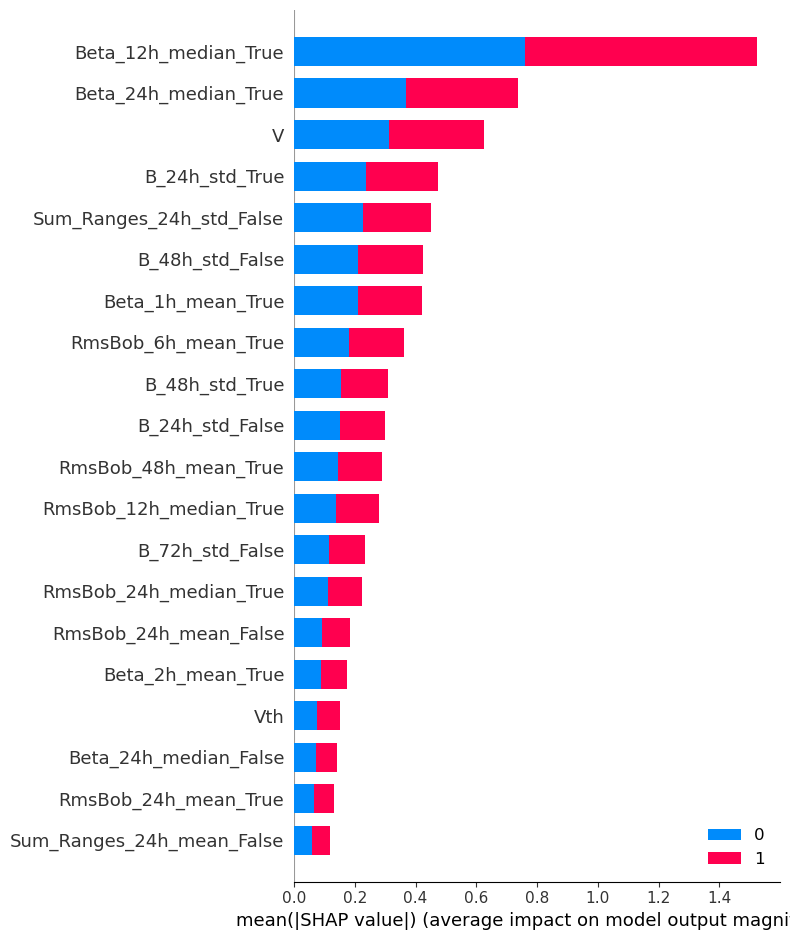

In [26]:
import shap
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type='bar', class_names=cat.classes_, feature_names=X.columns)

In [21]:
2*[1]

[1, 1]